# Dark Matter Analysis of the Draco dSph Galaxy

This tutorial demonstrates how to perform an analysis of the Draco dSph galaxy.  This tutorial assumes that you have first gone through the [PG 1553](PG 1553+113.ipynb) analysis tutorial.  In this example we will use the following data selection which is chosen to match the selection used in the [6-year LAT Dwarf Analysis](http://arxiv.org/abs/1503.02641).

* 10x10 degree ROI
* Start Time (MET) = 239557417 seconds
* Stop Time (MET) = 428903014 seconds
* Minimum Energy = 500 MeV
* Maximum Energy = 500000 MeV
* zmax = 100 deg
* P8R2_SOURCE_V6 (evclass=128)

The P8 dSph paper used a multi-component analysis that used the four PSF event types in a joint likelihood.  In this example we will perform a single component analysis using all SOURCE-class events (evtype=3).

## Get the Data and Setup the Analysis

For this thread we will use a pregenerated data set which is contained in the following tar archive.

In [1]:
!wget -nc http://www.slac.stanford.edu/~mdwood/fermipy/draco.tar.gz
# Alternate download link
#!wget -nc https://www.dropbox.com/s/1lpkincrj04c8m2/draco.tar.gz?dl=0
!tar xzf draco.tar.gz


File ‘draco.tar.gz’ already there; not retrieving.



We will begin by looking at the contents of the configuration file.  The configuration is similar to our PG1553 example except for the addition of a 'draco' component in the ROI model.  We also set the ROI coordinates explicitly since the ROI center isn't at the position of a 3FGL source.

In [2]:
!cat draco/config.yaml

logging : 

  verbosity : 3

data:

  evfile: draco_ft1.fits
  scfile: null
  ltcube : ltcube_239557414_428903014_z100_r180_gti.fits

binning:

  # Binning
  roiwidth   : 10.0
  npix       : null
  binsz      : 0.1 # spatial bin size in deg
  binsperdec : 8   # nb energy bins per decade
  coordsys   : 'GAL'

selection:

  # Data selections
  emin    : 500
  emax    : 500000
  zmax    : 100
  evclass : 128
  evtype  : 3
  tmin    : 239557414
  tmax    : 428903014 # 6 years
  filter  : null

  # Set the ROI center to these coordinates
  ra: 260.05167
  dec: 57.91528

gtlike:
  # IRFs
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

# Settings for ROI model
model:

  # Include catalog sources within this distance from the ROI center
  src_radius  : null

  # Include catalog sources within a box of width roisrc.
  src_roiwidth : 15.0

  galdiff  : '$FERMI_DIFFUSE_DIR/gll_iem_v06.fits'
  isodiff  : '$FERMI_DIFFUSE_DIR/iso_P8R2_SOURCE_V6_v06.txt'

  # List of

Note that the setup for a joint analysis is almost identical to the above except for the modification to the components section.  The following example shows how one would define the components configuration to setup a joint analysis with the four PSF event types:

To get started we will first instantiate a GTAnalysis instance using the config file in the draco directory and the run the setup() method.  This will prepare all the ancillary files and create the pylikelihood instance for binned analysis.  Note that in this example these files have already been generated so the routines that would normally be executed to create these files will be skipped.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('draco/config.yaml')
gta.setup()
gta.write_roi('fit0')

/Users/mdwood/src/ScienceTools/x86_64-apple-darwin14.3.0/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
2015-12-08 15:28:45 - GTAnalysis - INFO - 
--------------------------------------------------------------------------------
This is fermipy version 0.5.4+13.g06c7.
2015-12-08 15:28:45 - GTAnalysis - INFO - Configuration:
binning:
  binsperdec: 8
  binsz: 0.1
  coordsys: GAL
  enumbins: null
  npix: null
  proj: AIT
  roiwidth: 10.0
components: null
data:
  evfile: draco_ft1.fits
  ltcube: ltcube_239557414_428903014_z100_r180_gti.fits
  scfile: null
extension:
  fix_background: false
  save_model_map: false
  save_templates: false
  spatial_model: GaussianSource
  width: null
  width_max: 1.0
  width_min: 0.00316
  width_nstep: 26
fileio:
  logfile: /Users/mdwood/fermi/fermip

Plotter is MatPlotlib


/Users/mdwood/src/ScienceTools/x86_64-apple-darwin14.3.0/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


## Print the ROI model

We can print the ROI object to see a list of sources in the model along with their distance from the ROI center (offset), TS, and number of predicted counts (Npred).  Since we haven't yet fit any sources, the ts of all sources will initially be assigned as nan.

In [4]:
gta.print_roi()

name                SpatialModel   SpectrumType     offset        ts       Npred
--------------------------------------------------------------------------------
draco               PointSource    PowerLaw          0.000       nan         0.0
3FGL J1725.3+5853   PointSource    PowerLaw          1.181       nan       278.1
3FGL J1732.7+5914   PointSource    PowerLaw          2.107       nan       123.0
3FGL J1707.8+5626   PointSource    PowerLaw          2.231       nan       154.4
3FGL J1729.0+6049   PointSource    PowerLaw          3.121       nan       187.7
3FGL J1722.7+6104   PointSource    PowerLaw          3.184       nan       203.8
3FGL J1742.2+5947   PointSource    PowerLaw          3.416       nan       296.9
3FGL J1656.9+6008   PointSource    PowerLaw          3.725       nan       280.4
3FGL J1731.9+5428   PointSource    PowerLaw          3.801       nan       206.3
3FGL J1658.3+6149   PointSource    PowerLaw          4.772       nan       141.3
3FGL J1740.4+5347   PointSou

We can assess the quality of our pre-fit model by running the residmap method.  This will generate four maps

2015-12-08 15:29:29 - GTBinnedAnalysis - INFO - Loading /Users/mdwood/fermi/fermipy/notebooks/draco/fit0_00.xml
2015-12-08 15:29:30 - GTAnalysis - INFO - Generating residual maps
2015-12-08 15:29:30 - ResidMapGenerator - INFO - Generating Residual map
2015-12-08 15:29:30 - ResidMapGenerator - INFO - {'Index': 2.0, 'SpatialModel': 'PointSource'}
2015-12-08 15:29:30 - GTAnalysis - INFO - Adding source testsource
2015-12-08 15:29:34 - GTAnalysis - INFO - Deleting source testsource


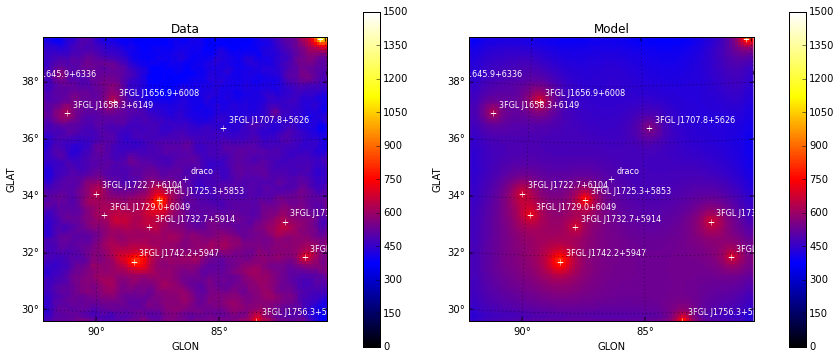

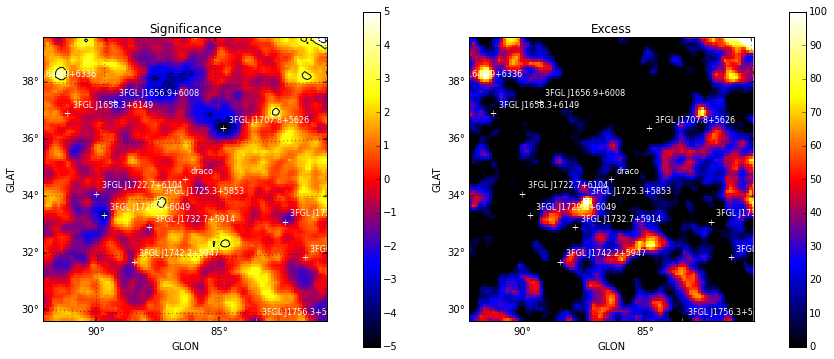

In [5]:
gta.load_roi('fit0')
resid = gta.residmap('draco_prefit',
                models=[{'SpatialModel' : 'PointSource', 'Index' : 2.0}])
from fermipy.plotting import ROIPlotter
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['data'],gta.roi).plot(vmin=0,vmax=1500,subplot=121)
plt.gca().set_title('Data')
ROIPlotter(resid[0]['model'],gta.roi).plot(vmin=0,vmax=1500,subplot=122)
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['sigma'],gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121)
plt.gca().set_title('Significance')
ROIPlotter(resid[0]['excess'],gta.roi).plot(vmin=0,vmax=100,subplot=122)
plt.gca().set_title('Excess')


Now we will run the *optimize* method.  This method will iteratively optimize the parameters of all components in the ROI in several stages:
* Simultaneously fitting the normalization of the brightest model components containing at least some fraction of the total model counts (default 95%).
* Individually fitting the normalization of all remaining sources if they have Npred above some threshold (default 1).
* Individually fitting the normalization and shape of any component with TS larger than some threshold (default 100).

Running *optimize* gives us a baseline model that we can use as a starting point for subsequent stages of the analysis.  We will also save the results of the analysis with write_roi.  By saving the analysis state we can restore the analysis to this point at any time with the *load_roi* method.

In [6]:
gta.optimize()
gta.write_roi('fit1')

2015-12-08 15:29:58 - GTAnalysis - INFO - Running ROI Optimization
2015-12-08 15:34:09 - GTAnalysis - INFO - Finished ROI Optimization
2015-12-08 15:34:09 - GTAnalysis - INFO - LogLike: -60833.645399 Delta-LogLike: 58.211925
2015-12-08 15:34:09 - GTBinnedAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit1_00.xml...
2015-12-08 15:34:09 - GTBinnedAnalysis - INFO - Generating model map for component 00.
2015-12-08 15:34:18 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit1.yaml...
2015-12-08 15:34:21 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit1.npy...


After running *optimize* we can rerun *print_roi* to see a summary of the updated model.  All sources that were fit in this step now have ts values and an Npred value the reflects the optimized normalization of that source.  Note that model components that were not fit during the optimize step still have ts=nan.

In [7]:
gta.print_roi()

name                SpatialModel   SpectrumType     offset        ts       Npred
--------------------------------------------------------------------------------
draco               PointSource    PowerLaw          0.000       nan         0.0
3FGL J1725.3+5853   PointSource    PowerLaw          1.181    287.94       371.2
3FGL J1732.7+5914   PointSource    PowerLaw          2.107      7.65        47.7
3FGL J1707.8+5626   PointSource    PowerLaw          2.231      0.08         6.4
3FGL J1729.0+6049   PointSource    PowerLaw          3.121      7.54        71.5
3FGL J1722.7+6104   PointSource    PowerLaw          3.184     25.70       138.3
3FGL J1742.2+5947   PointSource    PowerLaw          3.416    171.95       271.0
3FGL J1656.9+6008   PointSource    PowerLaw          3.725     70.16       207.9
3FGL J1731.9+5428   PointSource    PowerLaw          3.801     25.11       146.0
3FGL J1658.3+6149   PointSource    PowerLaw          4.772     49.01       112.5
3FGL J1740.4+5347   PointSou

To evaluate the quality of the optimized model we can rerun the residmap method.  In the updated residual map that we see that there is no longer a negative residual in the vicinity of J1707.

2015-12-08 15:34:27 - GTBinnedAnalysis - INFO - Loading /Users/mdwood/fermi/fermipy/notebooks/draco/fit1_00.xml
2015-12-08 15:34:27 - GTAnalysis - INFO - Generating residual maps
2015-12-08 15:34:27 - ResidMapGenerator - INFO - Generating Residual map
2015-12-08 15:34:27 - ResidMapGenerator - INFO - {'Index': 2.0, 'SpatialModel': 'PointSource'}
2015-12-08 15:34:27 - GTAnalysis - INFO - Adding source testsource
2015-12-08 15:34:31 - GTAnalysis - INFO - Deleting source testsource


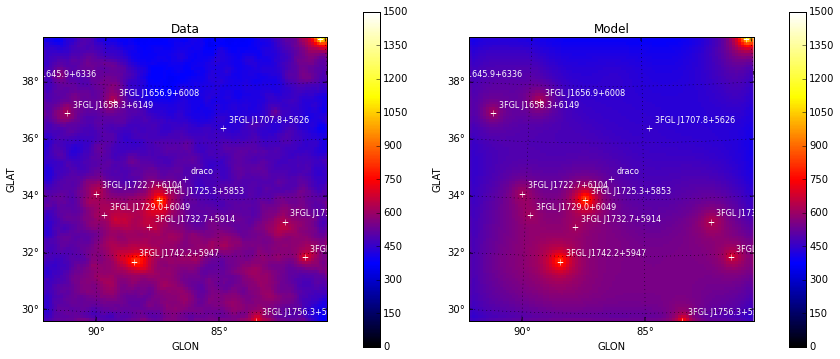

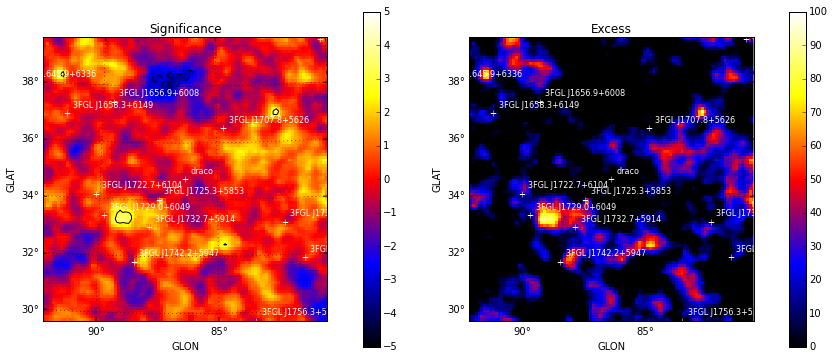

In [8]:
gta.load_roi('fit1')
resid = gta.residmap('draco_postfit',
                models=[{'SpatialModel' : 'PointSource', 'Index' : 2.0}])
from fermipy.plotting import ROIPlotter
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['data'],gta.roi).plot(vmin=0,vmax=1500,subplot=121)
plt.gca().set_title('Data')
ROIPlotter(resid[0]['model'],gta.roi).plot(vmin=0,vmax=1500,subplot=122)
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['sigma'],gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121)
plt.gca().set_title('Significance')
ROIPlotter(resid[0]['excess'],gta.roi).plot(vmin=0,vmax=100,subplot=122)
plt.gca().set_title('Excess')

Another diagnostic for the quality of the ROI model is the TS map.  The *tsmap* method can be used to generate a TS map of the ROI with a given test source model.  Here we use the same source model we did for the residual map -- a point source with a power-law index of 2.  

In [9]:
gta.load_roi('fit1')
tsmap = gta.tsmap('draco_postfit',
                models=[{'SpatialModel' : 'PointSource', 'Index' : 2.0}])

2015-12-08 15:34:43 - GTBinnedAnalysis - INFO - Loading /Users/mdwood/fermi/fermipy/notebooks/draco/fit1_00.xml
2015-12-08 15:34:43 - GTAnalysis - INFO - Generating TS maps
2015-12-08 15:34:43 - TSMapGenerator - INFO - Generating Residual map
2015-12-08 15:34:43 - TSMapGenerator - INFO - {'Index': 2.0, 'SpatialModel': 'PointSource'}
2015-12-08 15:34:43 - GTAnalysis - INFO - Adding source tsmap_testsource
2015-12-08 15:34:55 - GTAnalysis - INFO - Deleting source tsmap_testsource
2015-12-08 15:35:26 - GTAnalysis - INFO - Finished TS maps


Here we see that the excess in the northeast part of the ROI appears more prominent than in the residual map.  This excess is detected as a new point source with TS > 25.

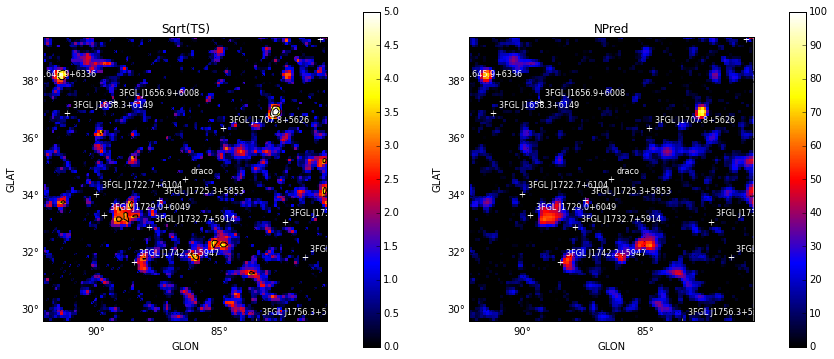

In [10]:
from fermipy.plotting import ROIPlotter

fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap[0]['sqrt_ts'],gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121)
plt.gca().set_title('Sqrt(TS)')
ROIPlotter(tsmap[0]['npred'],gta.roi).plot(vmin=0,vmax=100,subplot=122)
plt.gca().set_title('NPred')


## Spectral Analysis

After optimizing the ROI model we are ready to perform our analysis of the source of interest (draco).  We will begin by freeing draco along with all other point sources within 3 deg of the ROI center and refitting their normalizations.

In [11]:
gta.free_sources(distance=3.0,pars='norm')
gta.free_sources(distance=3.0,pars='shape',min_ts=100.)
gta.fit()

3

After running the fit completes we can execute the spectral analysis of draco with the sed method.  For comparison we will also perform the spectral analysis of a nearby source (3FGL J1725.3+5853).

In [12]:
sed_draco = gta.sed('draco')
sed_j1725 = gta.sed('3FGL J1725.3+5853')
gta.write_roi('fit_sed')

2015-12-08 15:36:38 - GTAnalysis - INFO - Computing SED for draco
2015-12-08 15:38:40 - GTAnalysis - INFO - Computing SED for 3FGL J1725.3+5853
2015-12-08 15:40:50 - GTBinnedAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit_sed_00.xml...
2015-12-08 15:40:50 - GTBinnedAnalysis - INFO - Generating model map for component 00.
2015-12-08 15:40:59 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit_sed.yaml...
2015-12-08 15:41:04 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit_sed.npy...


We can now inspect the fit results by looking at the elements of the output dictionary.  By default the sed method will perform a likelihood scan in each energy bin which is saved in the *lnlprofile* element.  In the following example we plot the likelihood profile in the first energy bin and overplot the flux upper limit in that bin (vertical black line).  fermiPy uses the delta-log-likelihood method to evaluate ULs and we can see that the 95% CL flux upper limit intersects with the point at which the log-likelihood has decreased by 2.71/2 from its maximum value (horizontal red line).

[  5.67391933e-07   7.34002329e-08   3.63210381e-07   1.68984697e-07
   2.75734756e-07   7.23628211e-08   9.19712616e-08   1.53018541e-07
   1.13123081e-07   1.44912322e-07   1.65460228e-07   5.50572657e-07
   2.78073000e-07   4.44186932e-07   5.05651043e-07   1.01321992e-06
   8.22583093e-07   1.10001439e-06   1.47326446e-06   1.97477638e-06
   2.64120211e-06   3.55002736e-06   4.74874323e-06   6.52638092e-06]


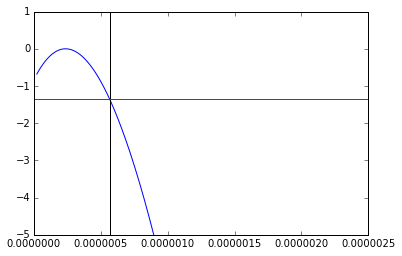

In [13]:
# E^2 x Differential flux ULs in each bin in units of MeV cm^{-2} s^{-1}
print sed_draco['e2dfde_ul95']

lnlprof = sed_draco['lnlprofile']

plt.figure()
plt.plot(lnlprof[0]['dfde']*10**(2*sed_draco['ecenter'][0]),
        lnlprof[0]['dlogLike'])
plt.gca().set_ylim(-5,1)
plt.gca().axvline(sed_draco['e2dfde_ul95'][0],color='k')
plt.gca().axhline(-2.71/2.,color='r')

We can also visualize the results of the scan with the SEDPlotter class.  This class accepts a source object as its argument and creates a visualization of the SED as a sequence of points with errors.  Setting showlnl=True overplots the likelihood function in each bin as a color gradient (the so-called castro plot).

(1e-08, 1e-05)

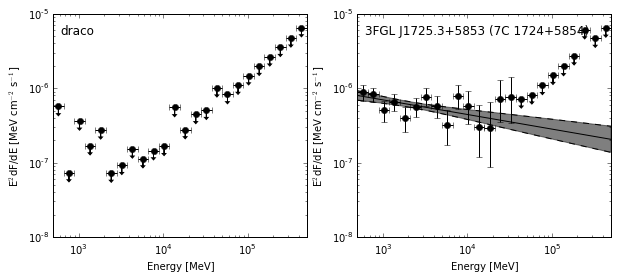

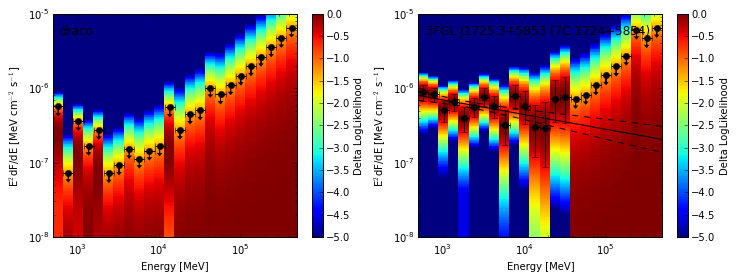

In [14]:
from fermipy.plotting import SEDPlotter

fig = plt.figure(figsize=(10,4))

fig.add_subplot(121)
SEDPlotter(gta.roi['draco']).plot()
plt.gca().set_ylim(1E-8,1E-5)

fig.add_subplot(122)
SEDPlotter(gta.roi['3FGL J1725.3+5853']).plot()
plt.gca().set_ylim(1E-8,1E-5)

fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
SEDPlotter(gta.roi['draco']).plot(showlnl=True)
plt.gca().set_ylim(1E-8,1E-5)

fig.add_subplot(122)
SEDPlotter(gta.roi['3FGL J1725.3+5853']).plot(showlnl=True)
plt.gca().set_ylim(1E-8,1E-5)


# Setting DM Upper Limits

Now that we have run a spectral analysis we can use the bin-by-bin likelihoods to gamma-ray flux from DM annihilations in Draco.  In the following sample code we demonstrate how to calculate the UL on the DM cross section for a given DM spectral model.  

Sigma-V Upper Limit:  3.60371605227e-26


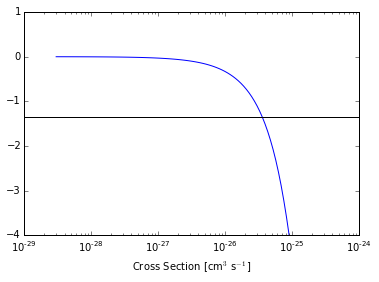

In [15]:
import pyLikelihood
import os

# Load the sed data structure
data = np.load('draco/fit_sed.npy').flat[0]
data = data['sources']['draco']['sed']

# Instantiate a DM Fit Function for a DM particle spectrum given the following parameters
# Mass = 100 GeV
# Cross-Section: 3 x 10^{-26} cm^{3} s^{-1}
# J-Factor: 10^19 GeV^2 cm^{-5}
# Channel: b-bbar
dmf = pyLikelihood.DMFitFunction()
dmf.readFunction(os.path.expandvars('draco/gammamc_dif.dat'))
dmf.setParam('norm',1E19)
dmf.setParam('sigmav',3E-26)
dmf.setParam('mass',100.0)
dmf.setParam('bratio',1.0)
dmf.setParam('channel0',4)

def integrate_eflux(fn,ebins,nstep=10):
    """Compute energy flux within a sequence of energy bins."""
    
    loge = np.linspace(ebins[0],ebins[-1],100)
    dfde = [fn(pyLikelihood.dArg(10**x)) for x in loge]        
    dfde = np.array(dfde)
    x = ebins
    dx = (x[1:] - x[:-1])

    yedge = x[1:,np.newaxis] + np.linspace(0,1,nstep)[np.newaxis,:]*dx[:,np.newaxis] 
    dy = 10**yedge[:,1:]-10**yedge[:,:-1]
    y = 0.5*(yedge[:,1:]+yedge[:,:-1])
    eflux = np.interp(np.ravel(y),loge,dfde)
    eflux = np.sum(eflux.reshape(y.shape)*10**y*dy,axis=1)

    return eflux

class SEDLike(object):

    def __init__(self,sed):
        self._sed = sed

    def __call__(self,eflux):
        lnl = np.zeros(eflux.shape)
        for i, ecenter in enumerate(self._sed['ecenter']):
            v = np.interp(eflux[i],
                          self._sed['lnlprofile'][i]['eflux'],
                          self._sed['lnlprofile'][i]['dlogLike'])
            lnl[i] += v
        return np.sum(lnl,axis=0)

ebins = np.array(list(data['emin']) + list([data['emax'][-1]]))
eflux = integrate_eflux(dmf,ebins)
sigmav = 3.E-26*np.logspace(-3.,1.,101)
eflux = eflux[:,np.newaxis]*np.logspace(-3,1,101)[np.newaxis,:]

slike = SEDLike(data)
lnl = slike(eflux)
lnl -= np.max(lnl)

# Plot log-likelihood profile

plt.figure()
plt.plot(sigmav,lnl)
plt.gca().set_xscale('log')
plt.gca().axhline(-2.71/2.,color='k')
plt.gca().set_ylim(-4,1)
plt.gca().set_xlabel('Cross Section [cm$^{3}$ s$^{-1}$]')

sigmav_ul = float(np.interp(2.71/2.,-lnl,sigmav))

print 'Sigma-V Upper Limit: ', sigmav_ul